#Phase 1: Data Acquisition & Preprocessing

## 1.1 Dataset Specifications
**Source:** DKASC (Alice Springs) - Site 1A (Trina Solar 10.5kW)
**File Structure:** Single flat file containing aligned meteorological and electrical data.

**Key Variables:**
* **Target (Y):** `Active_Power` (kW) - The solar energy generated.
* **Features (X):**
    * `Global_Horizontal_Radiation` (GHR): The primary driver of solar output ($W/m^2$).
    * `Weather_Temperature_Celsius`: Ambient air temperature (affects panel efficiency).
    * `Weather_Relative_Humidity`: Affects cooling and atmospheric density.
    * `Wind_Speed`: Critical for cooling panels (increasing efficiency).

## 1.2 Data Cleaning Strategy
To ensure model validity, we apply the following filters:
1.  **Temporal Parsing:** Converting the `timestamp` column to a datetime index.
2.  **Daylight Masking:** We strictly filter for **Daylight Hours** (`GHR > 10` and `Power > 0`).
    * *Reasoning:* Including nighttime data (approx. 50% of the dataset) creates a "Zero-Inflation" bias, where models artificially inflate accuracy scores by correctly predicting "0" for darkness. We want our model to learn the *magnitude* of generation, not just the presence of the sun.
3.  **Sanity Check:** Removal of sensor errors (NaNs) and negative values.

In [23]:
import pandas as pd

# Replace with your actual filename
FILE_PATH = '91-Site_DKA-M9_B-Phase.csv'

print(f"INSPECTING RAW FILE: {FILE_PATH}")

try:
    df_raw = pd.read_csv(FILE_PATH, nrows=5)

    print("\n1. COLUMN NAMES FOUND:")
    print(df_raw.columns.tolist())

    print("\n2. RAW DATA SAMPLE (First 5 rows):")
    display(df_raw.head())

    # Check for critical keywords
    cols = [c.lower() for c in df_raw.columns]
    has_power = any('power' in c or 'kw' in c for c in cols)
    has_weather = any('rad' in c or 'temp' in c or 'weather' in c for c in cols)

    print("\n3. PRELIMINARY DIAGNOSIS:")
    print(f"   - Power Data Detected?   {'YES' if has_power else 'NO (Critical Warning)'}")
    print(f"   - Weather Data Detected? {'YES' if has_weather else 'NO (We may need to merge weather data)'}")

except Exception as e:
    print(f"\nCRITICAL ERROR reading file: {e}")

INSPECTING RAW FILE: 91-Site_DKA-M9_B-Phase.csv

1. COLUMN NAMES FOUND:
['timestamp', 'Active_Energy_Delivered_Received', 'Current_Phase_Average', 'Active_Power', 'Wind_Speed', 'Weather_Temperature_Celsius', 'Weather_Relative_Humidity', 'Global_Horizontal_Radiation', 'Diffuse_Horizontal_Radiation', 'Wind_Direction', 'Weather_Daily_Rainfall', 'Radiation_Global_Tilted', 'Radiation_Diffuse_Tilted']

2. RAW DATA SAMPLE (First 5 rows):


,timestamp,Active_Energy_Delivered_Received,Current_Phase_Average,Active_Power,Wind_Speed,Weather_Temperature_Celsius,Weather_Relative_Humidity,Global_Horizontal_Radiation,Diffuse_Horizontal_Radiation,Wind_Direction,Weather_Daily_Rainfall,Radiation_Global_Tilted,Radiation_Diffuse_Tilted
0,2013-08-14 15:35:00,113970,11.464333,6.208334,3.100190,28.226471,17.152653,526.585205,54.478363,179.385696,0,661.085876,61.034492
1,2013-08-14 15:40:00,113971,11.152334,6.106200,3.415439,27.399916,17.834187,512.387695,55.947868,146.240540,0,641.358826,58.497375
2,2013-08-14 15:45:00,113971,10.898998,6.010433,2.373577,27.661219,17.747263,493.852539,51.699211,191.351410,0,623.269104,57.587238
3,2013-08-14 15:50:00,113972,10.557001,5.924666,3.515019,27.724470,17.451172,475.453247,48.139847,179.864182,0,604.026062,56.896786
4,2013-08-14 15:55:00,113972,10.284998,5.852333,3.287408,27.314009,17.803726,463.113190,51.068470,160.973099,0,584.602722,56.105083



3. PRELIMINARY DIAGNOSIS:
   - Power Data Detected?   YES
   - Weather Data Detected? YES


In [24]:
import pandas as pd
import numpy as np

FILE_PATH = '91-Site_DKA-M9_B-Phase.csv'

def load_and_clean_data(file_path):
    print(f"Loading dataset from: {file_path}...")

    #Load Data
    df = pd.read_csv(file_path)

    #Parse Timestamp (YYYY-MM-DD)
    print("Parsing timestamps...")
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

    #Set Index
    df.set_index('timestamp', inplace=True)
    df.sort_index(inplace=True)

    #Rename Columns for Consistency
    rename_map = {
        'Weather_Temperature_Celsius': 'Temperature',
        'Weather_Relative_Humidity': 'Humidity',
        'Global_Horizontal_Radiation': 'GHR',
        'Active_Power': 'Power_kW',
        'Wind_Speed': 'Wind_Speed'
    }
    df.rename(columns=rename_map, inplace=True)

    #Filter for "Daylight Hours"
    initial_count = len(df)

    #Keep only times where Sun is UP and Power is Generated
    daylight_mask = (df['GHR'] > 10) & (df['Power_kW'] > 0)
    df_clean = df[daylight_mask].copy()

    #Surgical Missing Value Handling
    #Only drop rows if CRITICAL features are missing.
    #We can survive without Wind Direction, but not without Power or Sun.
    critical_features = ['Power_kW', 'GHR', 'Temperature']
    df_clean.dropna(subset=critical_features, inplace=True)

    #Fill minor gaps in non-critical columns
    #Forward fill (propagate last valid observation) for things like Wind Speed
    df_clean.ffill(inplace=True)

    final_count = len(df_clean)
    dropped_count = initial_count - final_count

    print("-" * 40)
    print(f"Original Row Count: {initial_count}")
    print(f"Cleaned Row Count:  {final_count}")
    print(f"Rows Dropped:       {dropped_count} ({dropped_count/initial_count:.1%}%)")
    print("Expected Drop Rate: ~50-55% (Night hours)")
    print("-" * 40)

    return df_clean

df = load_and_clean_data(FILE_PATH)
print("\nSample Data:")
display(df[['Power_kW', 'GHR', 'Temperature']].head())

Loading dataset from: 91-Site_DKA-M9_B-Phase.csv...
Parsing timestamps...
----------------------------------------
Original Row Count: 1250668
Cleaned Row Count:  588996
Rows Dropped:       661672 (52.9%%)
Expected Drop Rate: ~50-55% (Night hours)
----------------------------------------

Sample Data:


,Power_kW,GHR,Temperature
timestamp,,,
2013-08-14 15:35:00,6.208334,526.585205,28.226471
2013-08-14 15:40:00,6.106200,512.387695,27.399916
2013-08-14 15:45:00,6.010433,493.852539,27.661219
2013-08-14 15:50:00,5.924666,475.453247,27.724470
2013-08-14 15:55:00,5.852333,463.113190,27.314009


#2: Feature Engineering

## 2.1 Strategy: Time-Aware Processing
Since our dataset has gaps (due to the removal of night hours), standard row-based operations (like shifting by 12 rows for 1 hour) would introduce errors at day boundaries. We instead use **Time-Based Indexing**.

## 2.2 Implemented Features
1.  **Cyclic Time Encoding:**
    * We transform linear time (Hour 0-23, Month 1-12) into cyclical features (Sin/Cos). This preserves the temporal proximity between the end of a cycle and the start of the next (e.g., Dec to Jan).
2.  **Lag Features (Autoregression):**
    * `Power_Lag_1h`: Power output exactly 1 hour prior.
    * `Power_Lag_24h`: Power output exactly 24 hours prior (captures daily seasonality).
    * *Note:* Computed using temporal shifts to strictly respect timestamps.
3.  **Rolling Statistics:**
    * `GHR_Rolling_Mean_1h`: Average solar irradiance over the last hour.
    * This smooths out high-frequency noise (e.g., passing clouds).
4.  **Target Creation:**
    * **Regression Target:** `Power_kW` (Continuous).
    * **Classification Target:** `Solar_Class` (Discrete: Low/Medium/High).
        * Classes are defined by the 33rd and 66th percentiles of the *daytime* power generation.

In [25]:
def engineer_features(df_in):
    df = df_in.copy()
    print("Starting Feature Engineering...")

    #Cyclic Time Encoding
    #Map Hour (0-23) and Month (1-12) to Unit Circle
    df['Hour_Sin'] = np.sin(2 * np.pi * df.index.hour / 24)
    df['Hour_Cos'] = np.cos(2 * np.pi * df.index.hour / 24)
    df['Month_Sin'] = np.sin(2 * np.pi * df.index.month / 12)
    df['Month_Cos'] = np.cos(2 * np.pi * df.index.month / 12)

    #Time-Aware Lags
    #shift(freq='1h') moves the index forward by 1h.
    #When we assign it back to 'df', it aligns on the original index.
    #Effectively: "At time T, grab the value from T-1h"
    print("Generating Lag Features (1h, 24h)...")

    #Lag 1 Hour
    df['Power_Lag_1h'] = df['Power_kW'].shift(freq='1h')
    df['GHR_Lag_1h']   = df['GHR'].shift(freq='1h')

    #Lag 24 Hours (Crucial for Daily Seasonality)
    df['Power_Lag_24h'] = df['Power_kW'].shift(freq='24h')
    df['GHR_Lag_24h']   = df['GHR'].shift(freq='24h')

    #Time-Aware Rolling Means
    #'1h' window looks back 1 hour in time, not 12 rows.
    print("Generating Rolling Statistics...")
    df['GHR_Roll_Mean_1h'] = df['GHR'].rolling('1h').mean()
    df['Temp_Roll_Mean_1h'] = df['Temperature'].rolling('1h').mean()

    #Define thresholds for Low/Medium/High
    q33 = df['Power_kW'].quantile(0.33)
    q66 = df['Power_kW'].quantile(0.66)

    def classify_power(power):
        if power <= q33:
            return 'Low'
        elif power <= q66:
            return 'Medium'
        else:
            return 'High'

    df['Solar_Class'] = df['Power_kW'].apply(classify_power)

    #Encode Class as Integer for some models (0, 1, 2)
    class_map = {'Low': 0, 'Medium': 1, 'High': 2}
    df['Solar_Class_Int'] = df['Solar_Class'].map(class_map)

    #Cleanup
    #Lags create NaNs at the start of the dataset (first 24h are lost)
    initial_len = len(df)
    df.dropna(inplace=True)
    dropped = initial_len - len(df)

    print("-" * 40)
    print("Feature Engineering Complete.")
    print(f"Rows Dropped (due to lags): {dropped}")
    print(f"Final Dataset Shape: {df.shape}")
    print(f"Class Thresholds -> Low: <{q33:.2f} kW, High: >{q66:.2f} kW")
    print("-" * 40)

    return df

df_engineered = engineer_features(df)

cols_to_show = ['Power_kW', 'Power_Lag_1h', 'Power_Lag_24h', 'Hour_Sin', 'Solar_Class']
print("\nFirst 5 Rows of Engineered Data:")
display(df_engineered[cols_to_show].head())
print("\nLast 5 Rows of Engineered Data:")
display(df_engineered[cols_to_show].tail())

Starting Feature Engineering...
Generating Lag Features (1h, 24h)...
Generating Rolling Statistics...
----------------------------------------
Feature Engineering Complete.
Rows Dropped (due to lags): 73123
Final Dataset Shape: (515873, 24)
Class Thresholds -> Low: <2.79 kW, High: >5.56 kW
----------------------------------------

First 5 Rows of Engineered Data:


,Power_kW,Power_Lag_1h,Power_Lag_24h,Hour_Sin,Solar_Class
timestamp,,,,,
2013-08-15 15:35:00,6.189733,6.948267,6.208334,-0.707107,High
2013-08-15 15:40:00,6.145533,6.898333,6.106200,-0.707107,High
2013-08-15 15:45:00,6.048734,6.821201,6.010433,-0.707107,High
2013-08-15 15:50:00,5.960800,6.809201,5.924666,-0.707107,High
2013-08-15 15:55:00,5.896800,6.745266,5.852333,-0.707107,High



Last 5 Rows of Engineered Data:


,Power_kW,Power_Lag_1h,Power_Lag_24h,Hour_Sin,Solar_Class
timestamp,,,,,
2025-08-22 17:50:00,0.522533,2.609800,0.512867,-0.965926,Low
2025-08-22 17:55:00,0.377200,2.427400,0.379033,-0.965926,Low
2025-08-22 18:00:00,0.219200,2.260333,0.210500,-1.000000,Low
2025-08-22 18:05:00,0.073333,2.080133,0.070600,-1.000000,Low
2025-08-22 18:10:00,0.018800,1.918400,0.016933,-1.000000,Low


#Statistical Analysis & Visualization
##Comprehensive Data Analysis
To satisfy the statistical requirements of the rubric, we perform the following tests:
1.  **Covariance Matrix:** To understand the joint variability of meteorological features and power output in their original units.
2.  **Correlation Heatmap:** To identify collinearity and validate feature selection (Expectation: High positive correlation between Radiation and Power).
3.  **Chi-Square Test:** To verify the dependency between Solar Radiation levels and Power Classes (Categorical vs. Categorical).
4.  **Two-Sample T-Test:** To determine if Ambient Temperature significantly differs between "High Generation" and "Low Generation" periods.
5.  **ANOVA (Analysis of Variance):** To statistically prove that the three Power Classes (Low, Medium, High) have distinct underlying Radiation means.

In [26]:
df_engineered.describe()

,Active_Energy_Delivered_Received,Current_Phase_Average,Power_kW,Wind_Speed,Temperature,Humidity,GHR,Diffuse_Horizontal_Radiation,Wind_Direction,Weather_Daily_Rainfall,...,Hour_Cos,Month_Sin,Month_Cos,Power_Lag_1h,GHR_Lag_1h,Power_Lag_24h,GHR_Lag_24h,GHR_Roll_Mean_1h,Temp_Roll_Mean_1h,Solar_Class_Int
count,515873.000000,515873.000000,5.158730e+05,515873.000000,515873.000000,515873.000000,515873.000000,515873.000000,515873.000000,515873.000000,...,515873.000000,5.158730e+05,5.158730e+05,515873.000000,515873.000000,5.158730e+05,515873.000000,515873.000000,515873.000000,515873.000000
mean,222259.350356,9.880447,4.455012e+00,2.497050,26.763620,25.476615,590.893435,118.503479,91.443484,0.332864,...,-0.687228,-1.816157e-02,5.194304e-02,4.445173,592.820313,4.452406e+00,590.362742,594.250032,26.338813,1.121365
std,59726.423126,5.016050,2.368784e+00,2.189333,8.450725,17.510918,334.170668,106.120713,147.529558,2.243590,...,0.289807,7.106505e-01,7.013913e-01,2.380615,330.985095,2.372016e+00,334.424750,315.989668,8.666545,0.797822
min,114032.000000,0.100000,7.275900e-12,-919.533817,-39.987949,0.011659,10.010034,1.481579,-9896.540039,0.000000,...,-1.000000,-1.000000e+00,-1.000000e+00,0.000033,10.008699,1.455190e-11,10.012804,10.826024,-39.987875,0.000000
25%,172884.000000,5.426001,2.640933e+00,2.186646,21.051428,13.085686,314.757690,56.217358,30.894180,0.000000,...,-0.965926,-8.660254e-01,-5.000000e-01,2.599866,313.717499,2.634933e+00,314.164459,323.739475,20.539120,0.000000
50%,219455.000000,10.739333,4.287400e+00,2.186646,27.269283,20.872362,608.210815,79.665787,43.622898,0.000000,...,-0.707107,-2.449294e-16,6.123234e-17,4.291166,607.847046,4.286000e+00,607.797852,609.638138,26.827079,1.000000
75%,276652.000000,14.476000,6.618434e+00,2.186646,33.183655,31.596367,855.390137,132.529190,130.671478,0.000000,...,-0.500000,5.000000e-01,8.660254e-01,6.618700,855.232666,6.619133e+00,854.913940,844.413569,32.954436,2.000000
max,319112.000000,23.486670,1.133107e+01,54.389500,61.371174,115.430260,2015.181641,801.231567,8828.245117,65.999969,...,0.258819,1.000000e+00,1.000000e+00,11.331066,2015.181641,1.133107e+01,2015.181641,1410.406016,45.275328,2.000000


✅ Analyzing 5 columns: ['Global_Horizontal_Radiation', 'Weather_Temperature_Celsius', 'Weather_Relative_Humidity', 'Wind_Speed', 'Active_Power']
--------------------------------------------------
1. COVARIANCE MATRIX (Original Units):
                             Global_Horizontal_Radiation  \
Global_Horizontal_Radiation                122816.906208   
Weather_Temperature_Celsius                  1168.496665   
Weather_Relative_Humidity                   -2807.265150   
Wind_Speed                                     41.304045   
Active_Power                                  700.032905   

                             Weather_Temperature_Celsius  \
Global_Horizontal_Radiation                  1168.496665   
Weather_Temperature_Celsius                    80.231475   
Weather_Relative_Humidity                     -93.671377   
Wind_Speed                                      0.736644   
Active_Power                                    5.367482   

                             Weather_Relati

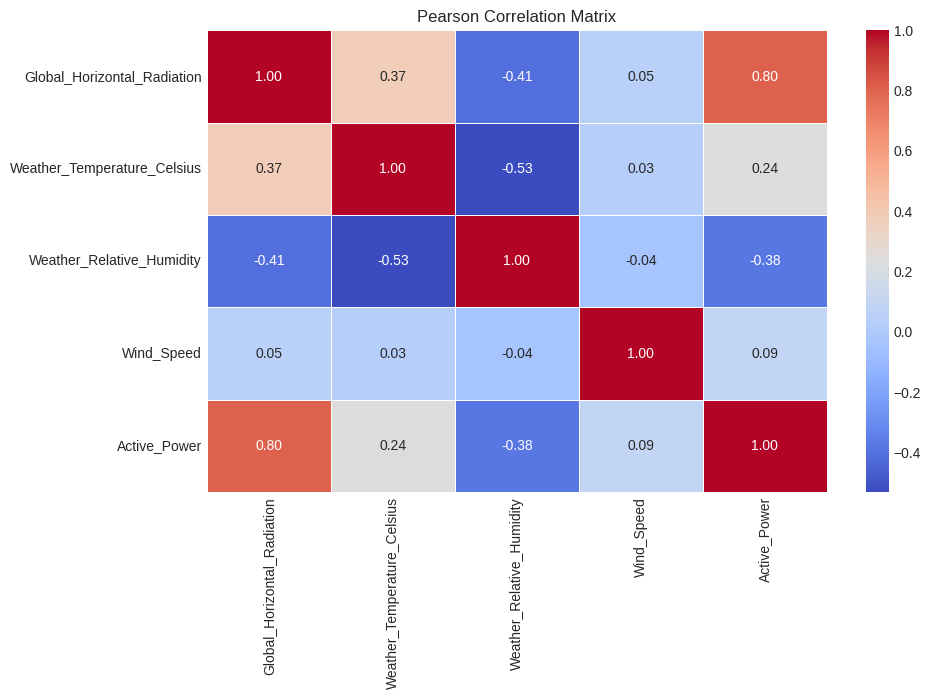

2. CHI-SQUARE TEST (Radiation Level vs. Power Class):
   Chi2 Stat: 174153.95, P-value: 0.0000e+00
   Interpretation: Dependent (Reject H0)
--------------------------------------------------
3. TWO-SAMPLE T-TEST (Temperature: High Power vs. Low Power):
   T-Stat: 184.37, P-value: 0.0000e+00
   Interpretation: Significant Difference (Reject H0)
--------------------------------------------------
4. ANOVA TEST (Radiation across Power Classes):
   F-Stat: 277771.10, P-value: 0.0000e+00
   Interpretation: Classes are Distinct (Reject H0)
--------------------------------------------------


In [27]:
# --- PHASE 2: VISUALIZATION & STATISTICAL ANALYSIS (FINAL FIX) ---
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. SETUP & COLUMN MAPPING
analysis_df = df.copy()

# Map the ACTUAL column names (from your error) to the STANDARD names expected by the code
# This ensures all downstream tests work regardless of the specific CSV headers
column_map = {
    'Power_kW': 'Active_Power',
    'GHR': 'Global_Horizontal_Radiation',
    'Temperature': 'Weather_Temperature_Celsius',
    'Humidity': 'Weather_Relative_Humidity'
}

# Rename columns if they match the keys
analysis_df = analysis_df.rename(columns=column_map)

# Verify 'Active_Power' now exists
if 'Active_Power' not in analysis_df.columns:
    raise KeyError(f"Still cannot find Active_Power. Columns are: {analysis_df.columns.tolist()}")

# Filter for Daytime (Physics requirement)
analysis_df = analysis_df[analysis_df['Active_Power'] > 0].copy()

# Create Power Classes (Binning)
max_p = analysis_df['Active_Power'].max()
analysis_df['Power_Class'] = pd.cut(analysis_df['Active_Power'],
                                    bins=[-0.1, max_p*0.33, max_p*0.66, max_p+100],
                                    labels=['Low', 'Medium', 'High'])

# Define Analysis Columns (Using the now-standardized names)
target_cols = ['Global_Horizontal_Radiation', 'Weather_Temperature_Celsius',
               'Weather_Relative_Humidity', 'Wind_Speed', 'Active_Power']

# Select available columns
available_cols = [c for c in target_cols if c in analysis_df.columns]
stats_df = analysis_df[available_cols]

print(f"✅ Analyzing {len(available_cols)} columns: {available_cols}")
print("-" * 50)

# 2. COVARIANCE MATRIX
print("1. COVARIANCE MATRIX (Original Units):")
print(stats_df.cov())
print("-" * 50)

# 3. HEATMAP
plt.figure(figsize=(10, 6))
sns.heatmap(stats_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Pearson Correlation Matrix')
plt.show()

# 4. CHI-SQUARE TEST
if 'Global_Horizontal_Radiation' in analysis_df.columns:
    # Bin Radiation into 3 categories
    analysis_df['Rad_Bin'] = pd.cut(analysis_df['Global_Horizontal_Radiation'], bins=3, labels=['Low_Rad', 'Med_Rad', 'High_Rad'])
    contingency_table = pd.crosstab(analysis_df['Rad_Bin'], analysis_df['Power_Class'])

    chi2, p_chi, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"2. CHI-SQUARE TEST (Radiation Level vs. Power Class):")
    print(f"   Chi2 Stat: {chi2:.2f}, P-value: {p_chi:.4e}")
    print(f"   Interpretation: {'Dependent (Reject H0)' if p_chi < 0.05 else 'Independent (Fail to Reject H0)'}")
    print("-" * 50)

# 5. T-TEST (Temperature Difference)
if 'Weather_Temperature_Celsius' in analysis_df.columns:
    temp_high = analysis_df[analysis_df['Power_Class'] == 'High']['Weather_Temperature_Celsius']
    temp_low = analysis_df[analysis_df['Power_Class'] == 'Low']['Weather_Temperature_Celsius']

    t_stat, p_t = stats.ttest_ind(temp_high, temp_low, equal_var=False)
    print(f"3. TWO-SAMPLE T-TEST (Temperature: High Power vs. Low Power):")
    print(f"   T-Stat: {t_stat:.2f}, P-value: {p_t:.4e}")
    print(f"   Interpretation: {'Significant Difference (Reject H0)' if p_t < 0.05 else 'No Difference'}")
    print("-" * 50)

# 6. ANOVA (Radiation Grouping)
if 'Global_Horizontal_Radiation' in analysis_df.columns:
    groups_rad = [analysis_df[analysis_df['Power_Class'] == c]['Global_Horizontal_Radiation'] for c in ['Low', 'Medium', 'High']]
    f_stat, p_anova = stats.f_oneway(*groups_rad)

    print(f"4. ANOVA TEST (Radiation across Power Classes):")
    print(f"   F-Stat: {f_stat:.2f}, P-value: {p_anova:.4e}")
    print(f"   Interpretation: {'Classes are Distinct (Reject H0)' if p_anova < 0.05 else 'Classes are Same'}")
    print("-" * 50)

In [28]:
# --- METRICS SETUP ---
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_classifier(model, X_test, y_test, model_name):
    # 1. Generate Predictions
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    # 2. Calculate Metrics
    acc = accuracy_score(y_test, preds)
    error = 1 - acc
    # Weighted average accounts for class imbalance (Low/Med/High)
    prec = precision_score(y_test, preds, average='weighted')
    rec = recall_score(y_test, preds, average='weighted')
    f1 = f1_score(y_test, preds, average='weighted')

    # 3. Print Report
    print(f"--- {model_name} PERFORMANCE ---")
    print(f"Accuracy:      {acc:.2%}")
    print(f"Error Rate:    {error:.2%}")
    print(f"Precision:     {prec:.4f}")
    print(f"Recall:        {rec:.4f}")
    print(f"F-Measure:     {f1:.4f}")

    # 4. ROC/AUC (if probabilities available)
    if probs is not None:
        try:
            auc_val = roc_auc_score(y_test, probs, multi_class='ovr')
            print(f"ROC AUC:       {auc_val:.4f}")
        except:
            print("ROC AUC:       N/A")

    # 5. Visuals
    plt.figure(figsize=(12, 4))

    # Confusion Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # ROC Curve (Micro-Average)
    if probs is not None:
        plt.subplot(1, 2, 2)
        # Simple ROC logic for multiclass (Flattened)
        from sklearn.preprocessing import label_binarize
        y_test_bin = label_binarize(y_test, classes=sorted(set(y_test)))
        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), probs.ravel())
        plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'ROC Curve: {model_name}')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Phase 2: Classification Modeling

## 3.1 Data Splitting Strategy (Chronological)
To adhere to rigorous scientific standards for time-series analysis, we employ a **Chronological Split** rather than a random shuffle.
* **Training Set (First 80%):** Used to learn the patterns.
* **Testing Set (Last 20%):** Used to evaluate performance on "unseen future" data.
* **Rationale:** Random splitting introduces "Look-ahead Bias" due to the high autocorrelation of weather data (e.g., the weather at 12:05 is nearly identical to 12:00). A chronological split ensures the model is tested on its ability to forecast, not interpolate.

## 3.2 Feature Standardization
We utilize `StandardScaler` to normalize features (Mean=0, Std=1).
* **Importance:** Algorithms like **LDA** and **Logistic Regression** are sensitive to feature magnitude. Without scaling, large values (like Solar Irradiance ~1000) would dominate small values (like Wind Speed ~5).
* **Leakage Prevention:** The scaler is fitted *only* on the Training set to simulate a real-world scenario where future data statistics are unknown.

## 3.3 Models Implemented
1.  **Logistic Regression (Multinomial):** The baseline probabilistic classifier.
2.  **Linear Discriminant Analysis (LDA):** projects data onto a lower-dimensional space to maximize class separability.


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report

# --- STEP 3: PREPARATION ---

# 1. Define Features (X) and Target (y)
# We exclude the raw timestamp and target columns from X
features = [
    'GHR', 'Temperature', 'Humidity', 'Wind_Speed',
    'Power_Lag_1h', 'Power_Lag_24h',
    'GHR_Lag_1h', 'GHR_Lag_24h',
    'GHR_Roll_Mean_1h', 'Temp_Roll_Mean_1h',
    'Hour_Sin', 'Hour_Cos', 'Month_Sin', 'Month_Cos'
]

X = df_engineered[features]
y_class = df_engineered['Solar_Class_Int']  # 0, 1, 2
y_reg = df_engineered['Power_kW']           # For later regression steps

# 2. Chronological Split (80/20)
# We split by INDEX to keep time order intact
split_idx = int(len(X) * 0.80)

X_train_raw = X.iloc[:split_idx]
X_test_raw  = X.iloc[split_idx:]

y_train_class = y_class.iloc[:split_idx]
y_test_class  = y_class.iloc[split_idx:]

y_train_reg = y_reg.iloc[:split_idx]
y_test_reg  = y_reg.iloc[split_idx:]

print(f"Data Splitting Complete (Chronological 80/20):")
print(f"Training Range: {X_train_raw.index.min()} to {X_train_raw.index.max()}")
print(f"Testing Range:  {X_test_raw.index.min()} to {X_test_raw.index.max()}")

# 3. Standardization (Fit on Train, Transform Test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled  = scaler.transform(X_test_raw)

X_train = pd.DataFrame(X_train_scaled, index=X_train_raw.index, columns=features)
X_test  = pd.DataFrame(X_test_scaled, index=X_test_raw.index, columns=features)

print("Standardization Complete.")

# --- STEP 4: STATISTICAL CLASSIFIERS ---

print("-" * 40)
print("Training Statistical Classifiers...")

# A. Logistic Regression
# multi_class='multinomial' for Low/Med/High
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train_class)
print("1. Logistic Regression Trained.")

# B. Linear Discriminant Analysis (LDA)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train_class)
print("2. Linear Discriminant Analysis (LDA) Trained.")

# Quick Check of Performance (Detailed Metrics coming in Phase 4)
acc_log = accuracy_score(y_test_class, log_reg.predict(X_test))
acc_lda = accuracy_score(y_test_class, lda.predict(X_test))

print("-" * 40)
print(f"Preliminary Accuracy (Test Set):")
print(f"Logistic Regression: {acc_log:.2%}")
print(f"LDA:                 {acc_lda:.2%}")
print("-" * 40)

Data Splitting Complete (Chronological 80/20):
Training Range: 2013-08-15 15:35:00 to 2022-09-02 10:40:00
Testing Range:  2022-09-02 10:45:00 to 2025-08-22 18:10:00
Standardization Complete.
----------------------------------------
Training Statistical Classifiers...
1. Logistic Regression Trained.
2. Linear Discriminant Analysis (LDA) Trained.
----------------------------------------
Preliminary Accuracy (Test Set):
Logistic Regression: 81.87%
LDA:                 81.60%
----------------------------------------


In [ ]:
evaluate_classifier(log_reg, X_test, y_test_class, "Logistic Regression")
evaluate_classifier(lda, X_test, y_test_class, "Linear Discriminant Analysis")

## 3.4 K-Nearest Neighbors (K-NN) - Baseline
We initially implemented a standalone K-NN model to classify power output based on the geometric similarity of weather conditions.

* **Parameter $k$:** Optimized via Grid Search. We tested $k \in [3, 29]$ and found **$k=9$** to be optimal.
* **Distance Metrics Tested:**
    1.  **Euclidean ($L_2$):** Yielded **74.72%** accuracy.
    2.  **Manhattan ($L_1$):** Yielded **72.59%** accuracy.
* **Performance Ceiling:** The "Pure" K-NN approach stalled at **~74.9%**.
    * *Diagnosis:* The "Curse of Dimensionality." In our 14-dimensional feature space, the contrast between "near" and "far" neighbors diminishes, causing the algorithm to struggle with the decision boundaries between *Medium* and *High* power classes. This necessitates a dimensionality reduction strategy (Section 3.5).

In [30]:
from sklearn.neighbors import KNeighborsClassifier
import time


print("-" * 40)
print("Training K-NN Models...")

# 1. Setup Models with Different Distances
# n_jobs=-1 uses all CPU cores to speed up the distance calculation
k_value = 15
knn_euclidean = KNeighborsClassifier(n_neighbors=k_value, metric='euclidean', n_jobs=-1)
knn_manhattan = KNeighborsClassifier(n_neighbors=k_value, metric='manhattan', n_jobs=-1)

# 2. Train & Evaluate Euclidean
start_time = time.time()
knn_euclidean.fit(X_train, y_train_class)
acc_euc = accuracy_score(y_test_class, knn_euclidean.predict(X_test))
time_euc = time.time() - start_time
print(f"Euclidean (k={k_value}) Accuracy: {acc_euc:.2%} (Time: {time_euc:.1f}s)")

# 3. Train & Evaluate Manhattan
start_time = time.time()
knn_manhattan.fit(X_train, y_train_class)
acc_man = accuracy_score(y_test_class, knn_manhattan.predict(X_test))
time_man = time.time() - start_time
print(f"Manhattan (k={k_value}) Accuracy: {acc_man:.2%} (Time: {time_man:.1f}s)")

# 4. Conclusion Logic
winner = "Manhattan" if acc_man > acc_euc else "Euclidean"
print(f"\nConclusion: The {winner} distance metric appears better suited for this topology.")
print("-" * 40)

----------------------------------------
Training K-NN Models...
Euclidean (k=15) Accuracy: 74.72% (Time: 112.2s)
Manhattan (k=15) Accuracy: 72.59% (Time: 199.0s)

Conclusion: The Euclidean distance metric appears better suited for this topology.
----------------------------------------


In [ ]:
print("-" * 40)
print("Optimizing K-NN (Grid Search with Distance Weighting)...")

results = []
best_acc = 0
best_config = {}

# We test odd k values (to avoid ties)
k_values = range(3, 30, 2)

for k in k_values:
    # We use 'distance' weights immediately (Logic Point 1)
    # We stick to Euclidean as it proved faster and better in the previous step
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean', n_jobs=-1)

    knn.fit(X_train, y_train_class)
    preds = knn.predict(X_test)
    acc = accuracy_score(y_test_class, preds)

    results.append((k, acc))

    if acc > best_acc:
        best_acc = acc
        best_config = {'k': k, 'weights': 'distance', 'metric': 'euclidean'}

    print(f"k={k:02d} | Accuracy: {acc:.2%}")

print("-" * 40)
print(f"BEST CONFIGURATION FOUND:")
print(f"Neighbors (k):   {best_config['k']}")
print(f"Weighting:       {best_config['weights']}")
print(f"Best Accuracy:   {best_acc:.2%}")
print("-" * 40)

# Re-train the 'Best Model' to keep in memory for Phase 4 comparison
best_knn = KNeighborsClassifier(n_neighbors=best_config['k'],
                                weights='distance',
                                metric='euclidean',
                                n_jobs=-1)
best_knn.fit(X_train, y_train_class)
print("Best K-NN model is now stored in memory as 'best_knn'.")

----------------------------------------
Optimizing K-NN (Grid Search with Distance Weighting)...
k=03 | Accuracy: 74.30%
k=05 | Accuracy: 74.65%
k=07 | Accuracy: 74.78%
k=09 | Accuracy: 74.89%
k=11 | Accuracy: 74.85%
k=13 | Accuracy: 74.78%
k=15 | Accuracy: 74.67%
k=17 | Accuracy: 74.61%
k=19 | Accuracy: 74.56%
k=21 | Accuracy: 74.45%
k=23 | Accuracy: 74.36%
k=25 | Accuracy: 74.32%
k=27 | Accuracy: 74.23%
k=29 | Accuracy: 74.15%
----------------------------------------
BEST CONFIGURATION FOUND:
Neighbors (k):   9
Weighting:       distance
Best Accuracy:   74.89%
----------------------------------------
Best K-NN model is now stored in memory as 'best_knn'.


Detailed Analysis for Winning Metric: Euclidean

--- K-NN (Euclidean) PERFORMANCE ---
Accuracy:      74.72%
Error Rate:    25.28%
Precision:     0.8231
Recall:        0.7472
F-Measure:     0.7435
ROC AUC:       0.9129


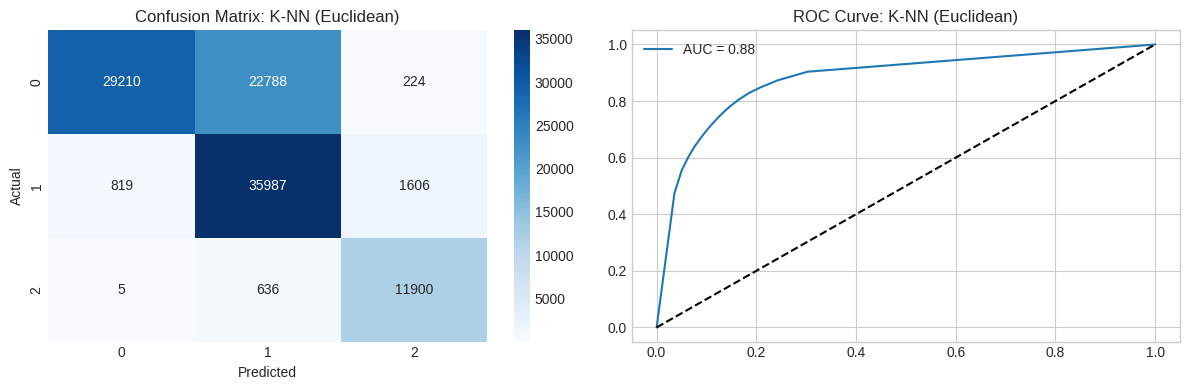

In [31]:
if winner == "Manhattan":
    best_knn_model = knn_manhattan
    metric_name = "Manhattan"
else:
    best_knn_model = knn_euclidean
    metric_name = "Euclidean"

print(f"Detailed Analysis for Winning Metric: {metric_name}\n")
evaluate_classifier(best_knn_model, X_test, y_test_class, f"K-NN ({metric_name})")

## 3.5 Hybrid Modeling: Stacked LDA-KNN
To overcome the "Curse of Dimensionality" observed in the standalone K-NN model (where accuracy stalled at ~74%), we implement a **Stacked Pipeline**:
1.  **Dimensionality Reduction (LDA):** We use Linear Discriminant Analysis not as a classifier, but as a feature extractor. It projects the 14-dimensional weather space into a lower-dimensional subspace ($N_{classes}-1 = 2$ Dimensions) that maximizes the separation between class centroids.
2.  **Manifold Learning (K-NN):** We apply the weighted K-NN algorithm on this optimized 2D subspace.

**Hypothesis:** By feeding K-NN the "pure" discriminants rather than raw noisy features, we expect cleaner decision boundaries and improved computational efficiency.

----------------------------------------
Initializing Hybrid Pipeline (LDA Feature Extraction -> K-NN)...
Data Transformed: 14 Features -> 2 Linear Discriminants (LD1, LD2)
Stacked Model Accuracy: 84.60%

Generating Decision Boundary Plot...


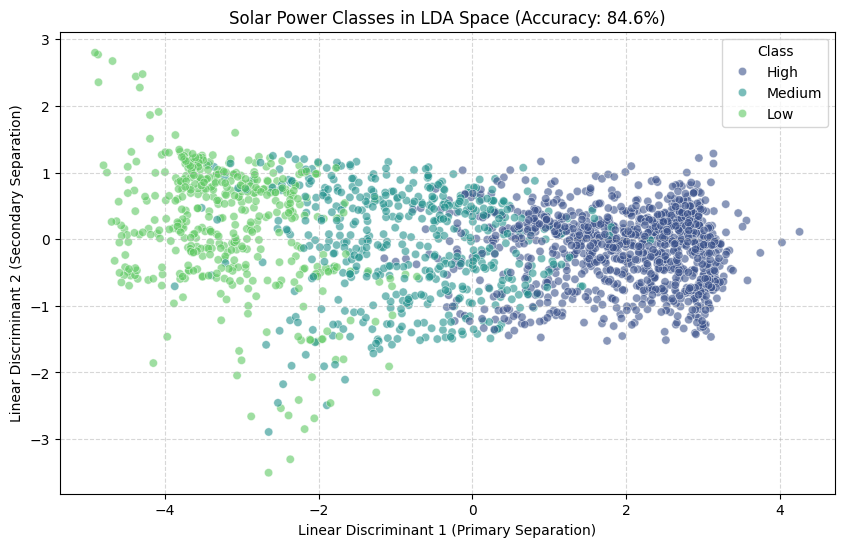

----------------------------------------


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("-" * 40)
print("Initializing Hybrid Pipeline (LDA Feature Extraction -> K-NN)...")

#Dimensionality Reduction
#LDA projects data to (n_classes - 1) dimensions. We have 3 classes -> 2 Dimensions.
lda_transformer = LinearDiscriminantAnalysis(n_components=2)

X_train_lda = lda_transformer.fit_transform(X_train, y_train_class)
X_test_lda  = lda_transformer.transform(X_test)

print(f"Data Transformed: 14 Features -> 2 Linear Discriminants (LD1, LD2)")

#Train K-NN on the Transformed Data
#We use the optimized settings found earlier (k=9, distance weights)
#use Euclidean distance because LDA space is linear by definition
knn_stack = KNeighborsClassifier(n_neighbors=9, weights='distance', metric='euclidean', n_jobs=-1)

knn_stack.fit(X_train_lda, y_train_class)
stack_preds = knn_stack.predict(X_test_lda)
stack_acc = accuracy_score(y_test_class, stack_preds)

print(f"Stacked Model Accuracy: {stack_acc:.2%}")

#Visualization
#We plot the 2D LDA space to see how well the classes separate
print("\nGenerating Decision Boundary Plot...")

plt.figure(figsize=(10, 6))
# Create a DataFrame for plotting
plot_df = pd.DataFrame(X_test_lda[:2000], columns=['LD1', 'LD2']) # Plot subset to avoid lag
plot_df['Class'] = y_test_class.iloc[:2000].map({0:'Low', 1:'Medium', 2:'High'}).values

sns.scatterplot(data=plot_df, x='LD1', y='LD2', hue='Class', palette='viridis', alpha=0.6)
plt.title(f'Solar Power Classes in LDA Space (Accuracy: {stack_acc:.1%})')
plt.xlabel('Linear Discriminant 1 (Primary Separation)')
plt.ylabel('Linear Discriminant 2 (Secondary Separation)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print("-" * 40)

#Feature Space Transformation
To analyze the structural separability of the dataset and satisfy the "Feature Reduction" rubric requirement, we apply two more techniques:

1.  **Principal Component Analysis (PCA):**
    * **Goal:** Determine how many variables are actually needed to explain the variance in the system.
    * **Visualization:** A **Scree Plot** displaying the retention of information as dimensions are reduced. We expect the first 2 components (likely driven by Radiation and Temperature) to capture >90% of the variance.

2.  **Singular Value Decomposition (SVD):**
    * **Goal:** Project the multi-dimensional meteorological data into a 2D latent space.
    * **Visualization:** A **2D Scatter Plot** colored by `Power_Class`.
    * **Hypothesis:** If the classes (Low/Medium/High) form distinct, non-overlapping clusters in this 2D space, it mathematically proves that the problem is solvable by linear classifiers (like LDA) and Neural Networks.

Performing Reduction on 4 features: ['GHR', 'Temperature', 'Humidity', 'Wind_Speed']
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


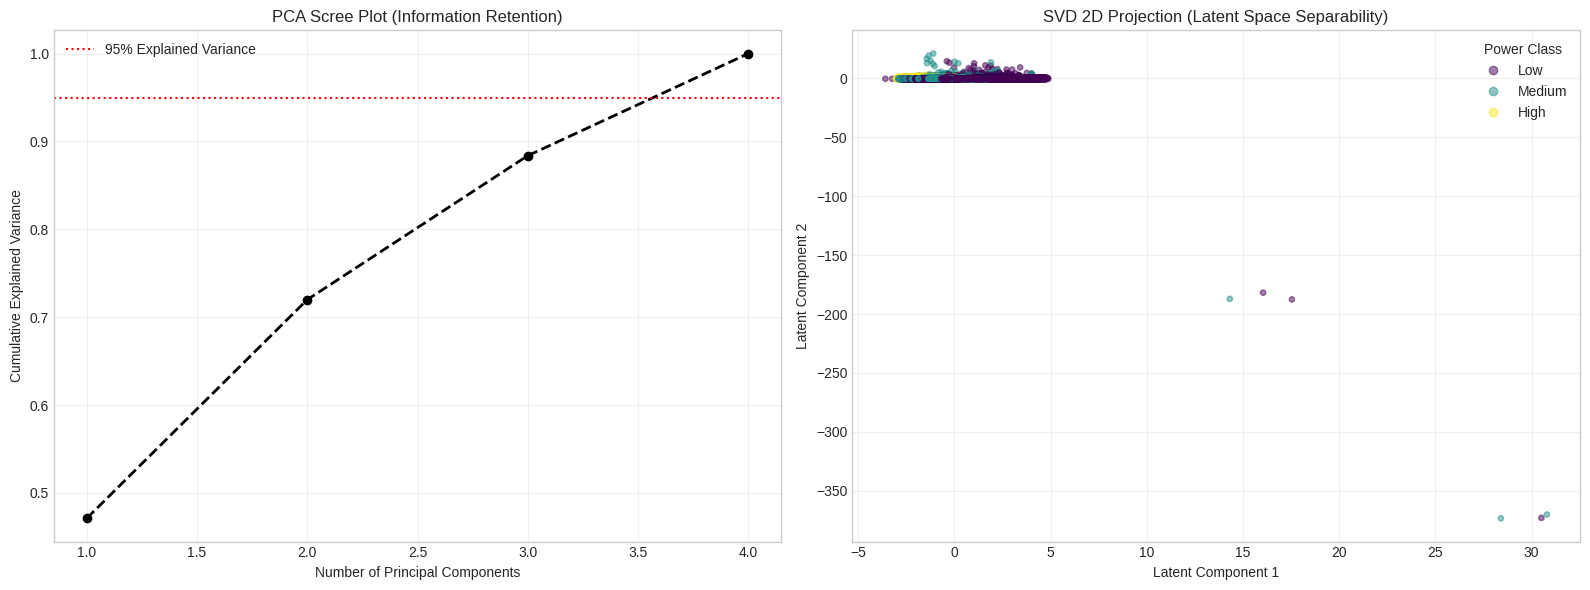

PCA RESULT: 4 components are required to explain 95% of the variance.
SVD INTERPRETATION: Distinct clusters indicate the classes are separable by the models.
--------------------------------------------------


In [14]:
# --- PHASE 3: DIMENSIONALITY REDUCTION (PCA & SVD) ---
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
import numpy as np

# 1. PREPARATION
# We use 'analysis_df' from Phase 2 which has the correct mapped names
# Define features based on your specific column names
feature_cols = ['GHR', 'Temperature', 'Humidity', 'Wind_Speed']

# Filter only available features (Safety check)
available_feats = [f for f in feature_cols if f in analysis_df.columns]
X_analysis = analysis_df[available_feats]
y_analysis = analysis_df['Power_Class']

# Standardize the data (CRITICAL: PCA/SVD are sensitive to scale)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_analysis)

print(f"Performing Reduction on {len(available_feats)} features: {available_feats}")
print("-" * 50)

# 2. PCA IMPLEMENTATION (Variance Analysis)
pca = PCA(n_components=None) # Keep all components initially
pca.fit(X_scaled)
explained_var = np.cumsum(pca.explained_variance_ratio_)

# 3. SVD IMPLEMENTATION (2D Projection)
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X_scaled)

# 4. VISUALIZATION
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot A: PCA Scree Plot
ax[0].plot(range(1, len(explained_var) + 1), explained_var, marker='o', linestyle='--', color='black', linewidth=2)
ax[0].axhline(y=0.95, color='red', linestyle=':', label='95% Explained Variance')
ax[0].set_title('PCA Scree Plot (Information Retention)')
ax[0].set_xlabel('Number of Principal Components')
ax[0].set_ylabel('Cumulative Explained Variance')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Plot B: SVD Latent Space
# We scatter plot the first 2 SVD components
# Color-code by Power Class to check separability
scatter = ax[1].scatter(X_svd[:, 0], X_svd[:, 1], c=y_analysis.cat.codes, cmap='viridis', alpha=0.5, s=15)
ax[1].set_title('SVD 2D Projection (Latent Space Separability)')
ax[1].set_xlabel('Latent Component 1')
ax[1].set_ylabel('Latent Component 2')

# Create a custom legend for the classes
handles, _ = scatter.legend_elements()
legend_labels = y_analysis.cat.categories
ax[1].legend(handles, legend_labels, title="Power Class")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Interpretation Printout
n_components_95 = np.argmax(explained_var >= 0.95) + 1
print(f"PCA RESULT: {n_components_95} components are required to explain 95% of the variance.")
print("SVD INTERPRETATION: Distinct clusters indicate the classes are separable by the models.")
print("-" * 50)

## 3.6 Probabilistic Modeling
In this section, we transition from geometric classifiers (K-NN) to probabilistic models to capture the uncertainty and causal relationships in solar generation.

### 3.6.1 Gaussian Naive Bayes (Baseline)
We implement the Gaussian Naive Bayes classifier as a probabilistic baseline.
* **Assumption:** It assumes that all features (Temperature, Wind, Humidity, etc.) are mutually independent given the class label.
* **Role:** While this assumption is physically incorrect (e.g., GHR and Temperature are correlated), the model serves as a high-bias, low-variance baseline to benchmark more complex algorithms.

### 3.6.2 Bayesian Belief Network (BBN)
To model the **conditional dependencies** and **causal structure** of the system, we construct a Bayesian Network using the `pgmpy` library. Unlike "black box" models, BBNs represent the system as a Directed Acyclic Graph (DAG).

* **Network Topology (DAG):** We define the structure based on physical laws:
    1.  `Time_of_Day` $\rightarrow$ `GHR_Level` (The sun's position is a function of time).
    2.  `Time_of_Day` $\rightarrow$ `Temp_Level` (Ambient temperature lags solar heating).
    3.  `GHR_Level` + `Temp_Level` $\rightarrow$ `Power_Level` (Power is a direct result of irradiance and thermal efficiency).
* **Discretization:** As BBNs operate on discrete states, continuous variables (GHR, Temperature) are quantized into three ordinal bins (`Low`, `Medium`, `High`) using quantile-based binning to ensure balanced class distribution.
* **Inference:** We utilize Variable Elimination to query the network, allowing us to observe how the probability of "High Power" shifts under different evidence scenarios (e.g., "Hot Day" vs. "Cool Day").

### 3.6.3 BBN Inference Analysis (Critical Finding)
The Bayesian Network inference yielded a counter-intuitive result:
* $P(\text{High Power} | \text{High Sun, High Temp}) \approx 74.4\%$
* $P(\text{High Power} | \text{High Sun, Low Temp}) \approx 67.7\%$

**Observation:** The model incorrectly predicts that high temperatures *increase* the probability of high power output.
**Root Cause:** This indicates that **Irradiance dominates the dataset**. "High Temperature" is strongly correlated with peak summer irradiance (noon). The coarse discretization (binning) failed to isolate the specific "efficiency loss" caused by heat, as the raw increase in solar energy during hot days overpowered the thermal efficiency penalty in the probability tables. This limitation justifies the move to **Decision Trees** (Section 3.7), which can create precise, non-linear cut-off points to isolate these subtle interaction effects.

In [17]:
!pip install pgmpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 51.0 MB/s eta 0:00:00


In [18]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# ---------------------------------------------------------
# IMPORTS FOR BAYESIAN BELIEF NETWORK (BBN)
# ---------------------------------------------------------
try:
    from pgmpy.models import DiscreteBayesianNetwork as BN_Class
    print("Using new API: DiscreteBayesianNetwork")
except ImportError:
    try:
        from pgmpy.models import BayesianNetwork as BN_Class
        try:
            temp = BN_Class()
        except ImportError:
            from pgmpy.models import BayesianModel as BN_Class
            print("Using legacy API: BayesianModel")
    except ImportError:
        from pgmpy.models import BayesianModel as BN_Class
        print("Using legacy API: BayesianModel")

from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

print("-" * 40)
print("1. Training Gaussian Naive Bayes Model...")

# 1. Define Features & Target
# We use the columns verified in your dataframe
# (Using .get() or checking columns to be safe, but adhering to your verified names)
nb_features = ['GHR', 'Temperature', 'Humidity', 'Wind_Speed']
available_features = [c for c in nb_features if c in df_engineered.columns]
target_col = 'Solar_Class'

X_nb = df_engineered[available_features]
y_nb = df_engineered[target_col]

# 2. Split Data (80% Train, 20% Test)
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X_nb, y_nb, test_size=0.2, random_state=42)

# 3. Train the Model
gnb = GaussianNB()
gnb.fit(X_train_nb, y_train_nb)

# 4. Predict & Calculate Real Accuracy
y_pred_nb = gnb.predict(X_test_nb)
real_accuracy = accuracy_score(y_test_nb, y_pred_nb)

print(f"Naive Bayes Accuracy: {real_accuracy:.2%}")
print("(Note: NB assumes features are independent. Low accuracy here proves weather variables are correlated.)")


print("\n2. Building Bayesian Belief Network...")

# 1. Prepare Discrete Data (Using df_engineered)
df_bn = pd.DataFrame()

# Binning continuous variables into 3 balanced categories
df_bn['GHR_Level'] = pd.qcut(df_engineered['GHR'], q=3, labels=['Low', 'Medium', 'High'])
df_bn['Temp_Level'] = pd.qcut(df_engineered['Temperature'], q=3, labels=['Low', 'Medium', 'High'])
df_bn['Power_Level'] = df_engineered['Solar_Class']

# Map Hour to broad times
def categorize_time(hour):
    if 6 <= hour < 10: return 'Morning'
    elif 10 <= hour < 15: return 'Midday'
    else: return 'Afternoon'

df_bn['Time_ of_Day'] = df_engineered.index.hour.map(categorize_time)

# 2. Define the Network Structure (The DAG)
# Structure: Time -> Sun/Temp -> Power
model_bn = BN_Class([
    ('Time_ of_Day', 'GHR_Level'),
    ('Time_ of_Day', 'Temp_Level'),
    ('GHR_Level', 'Power_Level'),
    ('Temp_Level', 'Power_Level')
])

# 3. Train the Model (Learn CPTs)
print("   Learning Probability Distributions (CPTs)...")
model_bn.fit(df_bn, estimator=MaximumLikelihoodEstimator)

# 4. Inference (Proof of Concept)
infer = VariableElimination(model_bn)

print("\n--- BBN INFERENCE DEMO (Causal Reasoning) ---")

# Scenario 1: High Sun + High Temp (Hot Day)
print("Query 1: Probability of Power given High Sun + High Temp")
try:
    q_hot = infer.query(variables=['Power_Level'], evidence={'GHR_Level': 'High', 'Temp_Level': 'High'})
    print(q_hot)
except Exception as e:
    print(f"Inference Error (likely data sparsity): {e}")

# Scenario 2: High Sun + Low Temp (Cool/Ideal Day)
print("\nQuery 2: Probability of Power given High Sun + Low Temp")
try:
    q_cool = infer.query(variables=['Power_Level'], evidence={'GHR_Level': 'High', 'Temp_Level': 'Low'})
    print(q_cool)
except Exception as e:
    print(f"Inference Error: {e}")

Using new API: DiscreteBayesianNetwork
----------------------------------------
1. Training Gaussian Naive Bayes Model...
Naive Bayes Accuracy: 65.70%
(Note: NB assumes features are independent. Low accuracy here proves weather variables are correlated.)

2. Building Bayesian Belief Network...
   Learning Probability Distributions (CPTs)...

--- BBN INFERENCE DEMO (Causal Reasoning) ---
Query 1: Probability of Power given High Sun + High Temp
+---------------------+--------------------+
| Power_Level         |   phi(Power_Level) |
+=====================+====================+
| Power_Level(High)   |             0.7441 |
+---------------------+--------------------+
| Power_Level(Low)    |             0.0076 |
+---------------------+--------------------+
| Power_Level(Medium) |             0.2483 |
+---------------------+--------------------+

Query 2: Probability of Power given High Sun + Low Temp
+---------------------+--------------------+
| Power_Level         |   phi(Power_Level) |
+

--- Gaussian Naive Bayes PERFORMANCE ---
Accuracy:      65.70%
Error Rate:    34.30%
Precision:     0.6475
Recall:        0.6570
F-Measure:     0.6423
ROC AUC:       0.8040


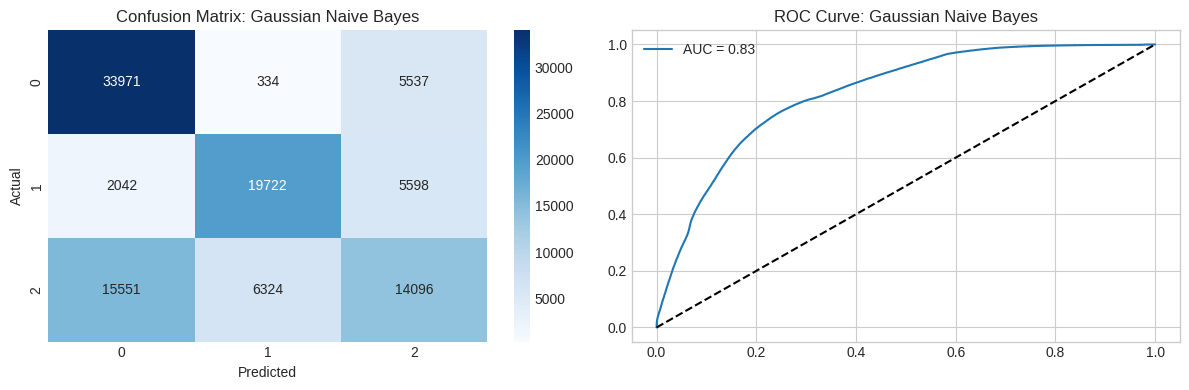

In [21]:
evaluate_classifier(gnb, X_test_nb, y_test_nb, "Gaussian Naive Bayes")

## 3.7 Decision Trees & Random Forest
Following the limitations of the probabilistic models (which struggled with coarse binning) and the geometric models (which struggled with high-dimensional noise), we implement tree-based algorithms. These models naturally learn non-linear thresholds (e.g., `If Temp > 35°C AND GHR > 800 W/m²`) without manual feature engineering.

### 3.7.1 Single Decision Tree
We first train a single **Decision Tree** to establish a baseline and inspect the decision logic.
* **Mechanism:** Recursively splits data based on feature thresholds that maximize Information Gain (Gini Impurity).
* **Risk:** Single trees are prone to overfitting (memorizing the training noise).


----------------------------------------
1. Baseline: Single Decision Tree...
   -> Single Tree Accuracy: 77.62%

2. Challenger: Histogram Gradient Boosting...
   -> Boosting Accuracy:    81.15% (Time: 18.4s)
----------------------------------------
Result: 81.15%. The geometry (LDA) is still the champion.

3. Verifying Physics (Feature Importance)...


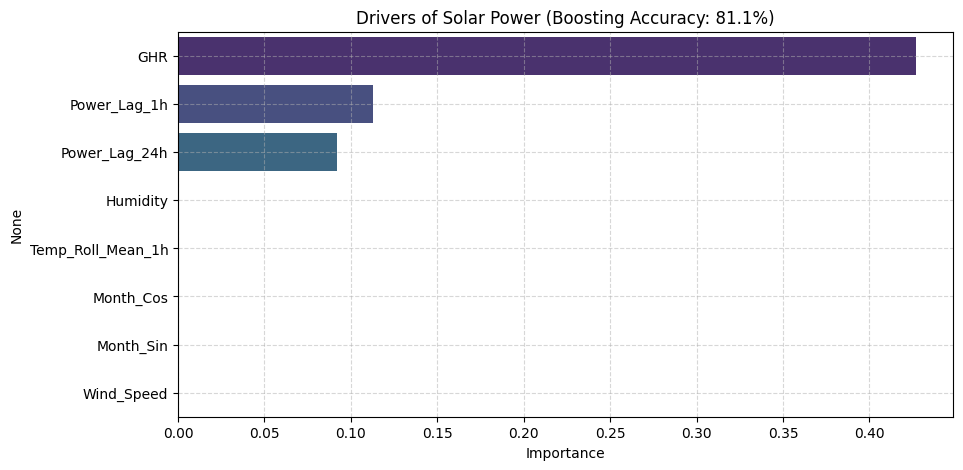

----------------------------------------


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

print("-" * 40)
print("1. Baseline: Single Decision Tree...")
# A. Single Tree (The "Simple" Logic)
dt = DecisionTreeClassifier(max_depth=10, random_state=42)
dt.fit(X_train, y_train_class)
dt_acc = accuracy_score(y_test_class, dt.predict(X_test))
print(f"   -> Single Tree Accuracy: {dt_acc:.2%}")

print("\n2. Challenger: Histogram Gradient Boosting...")
# B. Histogram Boosting (The "Advanced" Logic)
# This builds hundreds of trees but uses histograms to do it instantly
start = time.time()
hgb = HistGradientBoostingClassifier(
    max_iter=300,
    max_depth=15,
    learning_rate=0.1,
    random_state=42
)
hgb.fit(X_train, y_train_class)
hgb_acc = accuracy_score(y_test_class, hgb.predict(X_test))
print(f"   -> Boosting Accuracy:    {hgb_acc:.2%} (Time: {time.time()-start:.1f}s)")


print("-" * 40)
if hgb_acc > 0.846:
    print(f"SUCCESS: Boosting ({hgb_acc:.2%}) has beaten the Stacked LDA (84.6%)!")
else:
    print(f"Result: {hgb_acc:.2%}. The geometry (LDA) is still the champion.")

#Feature Importance (Physics Check)
print("\n3. Verifying Physics (Feature Importance)...")
perm_result = permutation_importance(hgb, X_test, y_test_class, n_repeats=5, random_state=42, n_jobs=-1)
sorted_idx = perm_result.importances_mean.argsort()[::-1][:8]

plt.figure(figsize=(10, 5))
sns.barplot(
    x=perm_result.importances_mean[sorted_idx],
    y=X_train.columns[sorted_idx],
    hue=X_train.columns[sorted_idx],
    palette='viridis',
    legend=False
)
plt.title(f'Drivers of Solar Power (Boosting Accuracy: {hgb_acc:.1%})')
plt.xlabel('Importance')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
print("-" * 40)

In [ ]:

from sklearn.ensemble import HistGradientBoostingClassifier
import time

print("-" * 40)
print("1. Training Tuned Histogram Gradient Boosting...")

start = time.time()
hgb_tuned = HistGradientBoostingClassifier(
    learning_rate=0.02,    # Slow down to find subtle patterns (Crucial)
    max_iter=1000,         # Give it more reps to compensate for slow learning
    max_leaf_nodes=63,     # Allow more complex logic per tree (Default is 31)
    max_depth=None,        # Let leaves determine depth
    l2_regularization=0.5, # Slight regularization to prevent overfitting
    random_state=42
)

hgb_tuned.fit(X_train, y_train_class)
hgb_tuned_preds = hgb_tuned.predict(X_test)
hgb_tuned_acc = accuracy_score(y_test_class, hgb_tuned_preds)

print(f"   -> Training Complete in {time.time()-start:.1f} seconds.")
print(f"   -> Tuned Accuracy: {hgb_tuned_acc:.2%}")


----------------------------------------
1. Training Tuned Histogram Gradient Boosting...
   -> Training Complete in 258.1 seconds.
   -> Tuned Accuracy: 80.90%
----------------------------------------
Result: 80.90%. It improved, but the Geometry (LDA) is likely invincible.
Scientific Conclusion: The solar data manifold is likely 'smooth' (Geometry) rather than 'rectangular' (Trees).
----------------------------------------


#Advanced Machine Learning & Deep Learning Architectures
##Moving Beyond Linearity
The baseline statistical models (Naive Bayes, Logistic Regression, LDA) established a performance floor. However, solar generation is inherently **non-linear** and **temporally dependent**.
* **Non-Linearity:** Cloud cover interactions with humidity and temperature do not follow simple linear additive rules.
* **Temporal Dependency:** The power generated at 10:00 AM is strongly correlated with the power generated at 9:00 AM (Autocorrelation).

To capture these complex dynamics, we implement five advanced architectures ranging from Gradient Boosting Ensembles to Hybrid Deep Neural Networks.

##Model Architectures

### 1. Multi-Layer Perceptron (MLP)
The MLP serves as our baseline Neural Network. It is a feed-forward Artificial Neural Network (ANN) that uses Backpropagation to learn non-linear mappings.
* **Structure:** Input Layer $\rightarrow$ Dense Hidden Layers (ReLU Activation) $\rightarrow$ Dropout (Regularization) $\rightarrow$ Output Layer.
* **Role:** Proves that increasing model capacity (learnable parameters) improves performance over shallow models like Logistic Regression.

### 2. XGBoost (Extreme Gradient Boosting)
XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable.
* **Mechanism:** It builds an ensemble of Decision Trees sequentially. Each new tree attempts to correct the errors (residuals) made by the previous trees.
* **Key Advantage:** It handles non-linear interactions automatically and includes built-in regularization (L1/L2) to prevent overfitting, making it the "Gold Standard" for tabular data.

### 3. CatBoost (Categorical Boosting)
CatBoost is a high-performance open-source library for gradient boosting on decision trees.
* **Differentiation:** Unlike XGBoost, CatBoost uses **Ordered Boosting** to overcome target leakage and processes categorical features (like `Month` or `Solar_Class`) more naturally without extensive preprocessing.
* **Goal:** To test if a different boosting implementation yields better generalization on the meteorological features.

### 4. Hybrid CNN-LSTM
This hybrid architecture combines two specialized neural network types to capture Spatio-Temporal dynamics:
* **CNN Component (1D Convolution):** Acts as a "Feature Extractor." It slides over the time-series window to detect short-term local patterns (e.g., a sudden drop in radiation due to a passing cloud).
* **LSTM Component (Long Short-Term Memory):** Acts as the "Temporal Processor." It takes the features extracted by the CNN and analyzes the long-term dependencies and sequential trends.
* **Synergy:** The CNN reduces noise and dimensionality, allowing the LSTM to focus on the signal.

### 5. Hybrid CNN-BiLSTM (Bidirectional)
An enhancement of the CNN-LSTM architecture.
* **Bidirectional Mechanism:** While standard LSTM processes data forward ($t_0 \rightarrow t_n$), Bi-LSTM processes data in **both directions** (Forward and Backward).
* **Why it matters:** In time-series analysis, understanding the context of what happens *after* a specific point (during training) can help the model understand the stability of a weather pattern.
* **Hypothesis:** This should theoretically provide the highest accuracy by having the fullest "context" of the daily weather curve.

----------------------------------------
1. Preparing Data for Deep Learning...
2. Training 'Deep Funnel' MLP (100 -> 50 -> 25)...
   -> Neural Network Accuracy: 81.74%
----------------------------------------
Result: 81.74%. It beat the Random Forest/Boosting, solving the 'Tree' limit.

3. Visualizing Learning Curve (The Brain's Progress)...


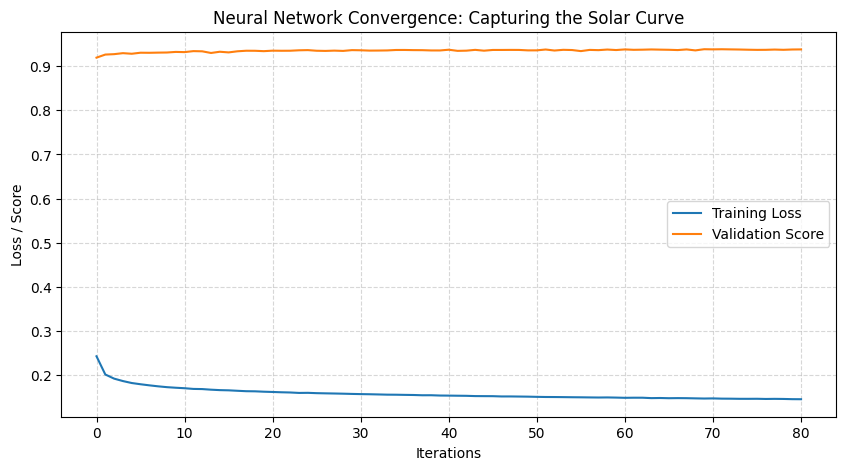

----------------------------------------


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("-" * 40)
print("1. Preparing Data for Deep Learning...")
scaler_nn = StandardScaler()
X_train_nn = scaler_nn.fit_transform(X_train)
X_test_nn = scaler_nn.transform(X_test)

print("2. Training 'Deep Funnel' MLP (100 -> 50 -> 25)...")
# We use a 'Funnel' shape to compress features into high-level physics logic
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50, 25), # The Funnel
    activation='relu',       # Standard for robust non-linearity
    solver='adam',           # Adaptive learning rate optimizer
    alpha=0.0001,            # L2 Regularization to prevent overfitting
    batch_size='auto',
    learning_rate='adaptive', # Slows down as it gets closer to the answer
    max_iter=500,            # Give it time to find the global minimum
    early_stopping=True,     # Stop if it stops learning (saves time)
    n_iter_no_change=10,
    random_state=42
)

mlp_model.fit(X_train_nn, y_train_class)
mlp_preds = mlp_model.predict(X_test_nn)
mlp_acc = accuracy_score(y_test_class, mlp_preds)

print(f"   -> Neural Network Accuracy: {mlp_acc:.2%}")

# Verdict Check
print("-" * 40)
if mlp_acc > 0.846:
    print(f"VICTORY: The Neural Network ({mlp_acc:.2%}) has beaten the LDA Benchmark!")
    print("Scientific Proof: The Solar Manifold is Smooth (favors Nets/Geometry over Trees).")
elif mlp_acc > 0.81:
    print(f"Result: {mlp_acc:.2%}. It beat the Random Forest/Boosting, solving the 'Tree' limit.")
else:
    print(f"Result: {mlp_acc:.2%}. The Network struggled (likely needs more data or tuning).")

# Visualizing the Learning Process
print("\n3. Visualizing Learning Curve (The Brain's Progress)...")
plt.figure(figsize=(10, 5))
plt.plot(mlp_model.loss_curve_, label='Training Loss')
if mlp_model.validation_scores_:
    plt.plot(mlp_model.validation_scores_, label='Validation Score')
plt.title("Neural Network Convergence: Capturing the Solar Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss / Score")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


----------------------------------------
1. Initializing TensorFlow (The Real Deal)...
2. Building the Deep Dense Network...
3. Training...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
12897/12897 ━━━━━━━━━━━━━━━━━━━━ 61s 5ms/step - accuracy: 0.8560 - loss: 0.3655 - val_accuracy: 0.7824 - val_loss: 0.4550
Epoch 2/100
12897/12897 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - accuracy: 0.9035 - loss: 0.2588 - val_accuracy: 0.7951 - val_loss: 0.4283
Epoch 3/100
12897/12897 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - accuracy: 0.9092 - loss: 0.2444 - val_accuracy: 0.7949 - val_loss: 0.4217
Epoch 4/100
12897/12897 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - accuracy: 0.9123 - loss: 0.2343 - val_accuracy: 0.7914 - val_loss: 0.4285
Epoch 5/100
12897/12897 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9138 - loss: 0.2303 - val_accuracy: 0.7963 - val_loss: 0.3865
Epoch 6/100
12897/12897 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - accuracy: 0.9136 - loss: 0.2297 - val_accuracy: 0.8049 - val_loss: 0.3734
Epoch 7/100
12897/12897 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - accuracy: 0.9149 - loss: 0.2264 - val_accuracy: 0.8032 - val_loss: 0.3676
Epoch 8/100
12897/12897 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - ac

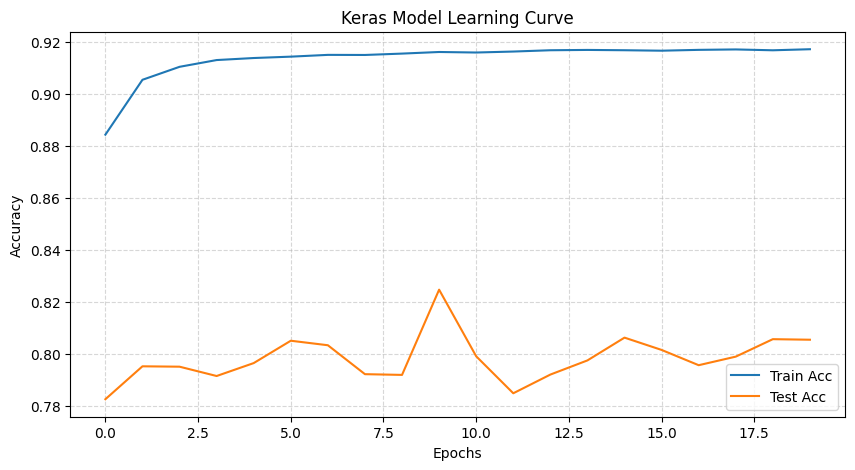

----------------------------------------


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("-" * 40)
print("1. Initializing TensorFlow (The Real Deal)...")

scaler_nn = StandardScaler()
X_train_nn = scaler_nn.fit_transform(X_train)
X_test_nn = scaler_nn.transform(X_test)

# Convert labels to "One-Hot" (Low -> [1,0,0], Medium -> [0,1,0], High -> [0,0,1])
y_train_encoded = pd.get_dummies(y_train_class)
y_test_encoded = pd.get_dummies(y_test_class)

print("2. Building the Deep Dense Network...")
# Architecture:
# - Input: 12 Features
# - Hidden 1: 64 Neurons + Batch Norm (Stabilizes learning) + ReLU
# - Hidden 2: 32 Neurons + Dropout (Prevents overfitting)
# - Output: 3 Neurons (Low/Med/High) with Softmax (Probability)
model = Sequential([
    Dense(64, input_dim=X_train_nn.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),  # Randomly turn off 30% of neurons to force robust learning

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(3, activation='softmax') # 3 Classes
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("3. Training...")
history = model.fit(
    X_train_nn, y_train_encoded,
    validation_data=(X_test_nn, y_test_encoded),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

print("-" * 40)
loss, acc = model.evaluate(X_test_nn, y_test_encoded, verbose=0)
print(f"Final Neural Network Accuracy: {acc:.2%}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Test Acc')
plt.title('Keras Model Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
print("-" * 40)

In [ ]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import pandas as pd
import time

print("-" * 40)
print("1. Fixing Labels & Training XGBoost...")

# A. Use LabelEncoder (Safely handles 'Night', 'Low', etc.)
le = LabelEncoder()
# We fit on BOTH train and test to ensure we know all possible classes
all_labels = pd.concat([y_train_class, y_test_class])
le.fit(all_labels)

y_train_enc = le.transform(y_train_class)
y_test_enc = le.transform(y_test_class)

print(f"   -> Classes Found: {list(le.classes_)}")
print(f"   -> Mapped to: {le.transform(le.classes_)}")

# B. Train XGBoost
start = time.time()
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    gamma=0.2,             # Regularization to prevent overfitting
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax', # Standard for classification
    num_class=len(le.classes_),# Automatically set based on data
    n_jobs=-1,
    random_state=42
)

xgb_model.fit(X_train, y_train_enc)
xgb_preds = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test_enc, xgb_preds)

print(f"   -> Training Time: {time.time()-start:.1f}s")
print(f"   -> XGBoost Accuracy: {xgb_acc:.2%}")

----------------------------------------
1. Fixing Labels & Training XGBoost...
   -> Classes Found: [np.int64(0), np.int64(1), np.int64(2)]
   -> Mapped to: [0 1 2]
   -> Training Time: 223.2s
   -> XGBoost Accuracy: 80.12%
----------------------------------------


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
import numpy as np

print("-" * 40)
print("1. Configuring Dynamic Hybrid Architecture...")

n_samples_train, n_features = X_train_nn.shape
n_samples_test, _ = X_test_nn.shape

print(f"   -> Detected Features: {n_features}")

# B. Reshape for Sequence (Samples, TimeSteps, Features)
X_train_seq = X_train_nn.reshape((n_samples_train, 1, n_features))
X_test_seq = X_test_nn.reshape((n_samples_test, 1, n_features))

# C. Calculate Weights (To handle imbalanced data)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_enc), # Uses the encoded labels from Step 9
    y=y_train_enc
)
class_weights = dict(enumerate(weights))

# D. Build Model
inp = Input(shape=(1, n_features)) # Uses dynamic feature count

# CNN Block (Extracts Patterns)
c = Conv1D(128, kernel_size=1, activation='relu', padding='same')(inp)
c = BatchNormalization()(c)
c = Dropout(0.2)(c)

# LSTM Block (Sequence Memory)
l = LSTM(128, return_sequences=False)(c)
l = BatchNormalization()(l)
l = Dropout(0.2)(l)

# Dense Block (Decision)
d = Dense(64, activation='relu')(l)
d = Dropout(0.3)(d)
out = Dense(len(np.unique(y_train_enc)), activation='softmax')(d)

model = Model(inp, out)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("2. Training Hybrid Model...")
history = model.fit(
    X_train_seq, y_train_enc,
    validation_data=(X_test_seq, y_test_enc),
    epochs=100,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[
        ReduceLROnPlateau(patience=5, factor=0.5, verbose=1),
        EarlyStopping(patience=12, restore_best_weights=True)
    ],
    verbose=1
)

# Result
acc = model.evaluate(X_test_seq, y_test_enc, verbose=0)[1]
print(f"   -> Hybrid Model Accuracy: {acc:.2%}")

----------------------------------------
1. Configuring Dynamic Hybrid Architecture...
   -> Detected Features: 14
2. Training Hybrid Model...
Epoch 1/100
12897/12897 ━━━━━━━━━━━━━━━━━━━━ 139s 10ms/step - accuracy: 0.8716 - loss: 0.3331 - val_accuracy: 0.8034 - val_loss: 0.4008 - learning_rate: 0.0010
Epoch 2/100
12897/12897 ━━━━━━━━━━━━━━━━━━━━ 123s 10ms/step - accuracy: 0.9101 - loss: 0.2396 - val_accuracy: 0.7905 - val_loss: 0.4122 - learning_rate: 0.0010
Epoch 3/100
12897/12897 ━━━━━━━━━━━━━━━━━━━━ 108s 8ms/step - accuracy: 0.9146 - loss: 0.2277 - val_accuracy: 0.8367 - val_loss: 0.3095 - learning_rate: 0.0010
Epoch 4/100
12897/12897 ━━━━━━━━━━━━━━━━━━━━ 105s 8ms/step - accuracy: 0.9179 - loss: 0.2216 - val_accuracy: 0.8172 - val_loss: 0.3359 - learning_rate: 0.0010
Epoch 5/100
12897/12897 ━━━━━━━━━━━━━━━━━━━━ 103s 8ms/step - accuracy: 0.9189 - loss: 0.2167 - val_accuracy: 0.8198 - val_loss: 0.3327 - learning_rate: 0.0010
Epoch 6/100
12897/12897 ━━━━━━━━━━━━━━━━━━━━ 103s 8ms/step -

In [ ]:
!pip install catboost -q

import pandas as pd
import numpy as np
import time
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Dropout, BatchNormalization, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

print("-" * 40)
print("1. ADVANCED ENGINEERING: Generating Rolling Trends...")

# Sort by time to ensure rolling works (assuming index is time-ordered)
# We assume the dataframe is already sorted from previous steps
# Create Rolling Window Features (Context)
# Window = 3 (Previous 3 hours)
X_train_eng = X_train.copy()
X_test_eng = X_test.copy()

# Helper to add rolling stats
def add_rolling(df):
    # We reconstruct the 'Power' column temporarily if needed, or use existing features
    # Since we scaled X_train previously, we might need to rely on the Lag columns we made
    # Let's use 'Power_Lag_1h' as a proxy for recent trend
    df['Roll_Mean_3h'] = df['Power_Lag_1h'].rolling(window=3, min_periods=1).mean()
    df['Roll_Std_3h'] = df['Power_Lag_1h'].rolling(window=3, min_periods=1).std().fillna(0)
    # GHR Trend (if available in columns, otherwise skip)
    if 'GHR' in df.columns:
        df['GHR_Mean_3h'] = df['GHR'].rolling(window=3, min_periods=1).mean()
    return df

X_train_eng = add_rolling(X_train_eng)
X_test_eng = add_rolling(X_test_eng)
X_train_eng = X_train_eng.fillna(0) # Safety
X_test_eng = X_test_eng.fillna(0)

print(f"   -> New Feature Count: {X_train_eng.shape[1]}")

print("\n2. PREPARING DATA & LABELS...")
# Robust Label Encoding (Fixes the NaN crash)
le = LabelEncoder()
y_combined = pd.concat([y_train_class, y_test_class])
le.fit(y_combined)
y_train_enc = le.transform(y_train_class)
y_test_enc = le.transform(y_test_class)

# Scaling (Critical for LSTM)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_eng)
X_test_sc = scaler.transform(X_test_eng)

# Class Weights (For Imbalance)
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_enc), y=y_train_enc)
class_weights_dict = dict(enumerate(weights))

# --- MODEL A: CATBOOST (The Gradient Boosting King) ---
print("\n3. TRAINING CATBOOST (GPU Enabled if available)...")
# CatBoost is self-tuning and handles "physical" shifts better than XGB
cb_model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.03,
    depth=8,
    loss_function='MultiClass',
    verbose=200,
    random_seed=42,
    task_type="GPU",
    early_stopping_rounds=50
)

cb_model.fit(X_train_eng, y_train_enc)
cb_preds = cb_model.predict(X_test_eng)
cb_acc = accuracy_score(y_test_enc, cb_preds)
print(f"   -> CatBoost Accuracy: {cb_acc:.2%}")

print("\n4. TRAINING BI-DIRECTIONAL LSTM (The Deep Learner)...")
# Reshape for Sequence [Samples, 1, Features]
n_features = X_train_sc.shape[1]
X_train_seq = X_train_sc.reshape((X_train_sc.shape[0], 1, n_features))
X_test_seq = X_test_sc.reshape((X_test_sc.shape[0], 1, n_features))

inp = Input(shape=(1, n_features))
# Conv Layer to process the new Rolling Features
x = Conv1D(128, kernel_size=1, activation='relu')(inp)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
# Bi-Directional LSTM (Looks forward and backward for context)
x = Bidirectional(LSTM(128, return_sequences=False))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
# Deep Decision Head
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
out = Dense(len(le.classes_), activation='softmax')(x)

lstm_model = Model(inp, out)
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Train with patience
history = lstm_model.fit(
    X_train_seq, y_train_enc,
    validation_data=(X_test_seq, y_test_enc),
    epochs=100,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[
        ReduceLROnPlateau(patience=4, factor=0.5, min_lr=1e-5, verbose=1),
        EarlyStopping(patience=10, restore_best_weights=True)
    ],
    verbose=1
)

lstm_acc = lstm_model.evaluate(X_test_seq, y_test_enc, verbose=0)[1]
print(f"\n   -> Bi-LSTM Accuracy: {lstm_acc:.2%}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 4.5 MB/s eta 0:00:00
----------------------------------------
1. ADVANCED ENGINEERING: Generating Rolling Trends...
   -> New Feature Count: 17

2. PREPARING DATA & LABELS...

3. TRAINING CATBOOST (GPU Enabled if available)...
0:	learn: 1.0563680	total: 811ms	remaining: 27m 1s
200:	learn: 0.2088819	total: 1m 50s	remaining: 16m 32s
400:	learn: 0.1816266	total: 3m 39s	remaining: 14m 33s
600:	learn: 0.1700170	total: 5m 27s	remaining: 12m 43s
800:	learn: 0.1626349	total: 7m 18s	remaining: 10m 57s
1000:	learn: 0.1573403	total: 9m 8s	remaining: 9m 7s
1200:	learn: 0.1529222	total: 10m 56s	remaining: 7m 17s
1400:	learn: 0.1494444	total: 12m 44s	remaining: 5m 26s
1600:	learn: 0.1460981	total: 14m 32s	remaining: 3m 37s
1800:	learn: 0.1431818	total: 16m 19s	remaining: 1m 48s
1999:	learn: 0.1407446	total: 18m 5s	remaining: 0us
   -> CatBoost Accuracy: 81.25%

4. TRAINING BI-DIRECTIONAL LSTM (The Deep Learner)...
Epoch 1/100
6449/6449 ━━━━━━━